# Predictive Modeling in Marketing Analytics (Regularization Project)

Dataset: **Marketing A/B Testing** (Kaggle)

Dataset URL: https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

License(s): CC0-1.0

Goal: **Predict whether a user converts** purchase based on exposure group and ad-impression behavior, using **regularized logistic regression** (Ridge/Lasso/Elastic Net).  

Data dictionary:
- `user id`: unique user identifier
- `test group`: `ad` vs `psa` (control)
- `converted`: True/False purchase outcome (target)
- `total ads`: number of ads shown
- `most ads day`: day with highest ads exposure
- `most ads hour`: hour with highest ads exposure


## 0) Setup
This notebook uses **scikit-learn pipelines** so preprocessing is applied consistently during cross-validation.

**Packages:** pandas, numpy, matplotlib, scikit-learn.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)

RANDOM_STATE = 42
pd.set_option('display.max_columns', 200)


## 1) Data Collection


In [2]:
import json, os

kaggle_info = {
    "username": "",
    "key": ""
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_info, f)

!chmod 600 /root/.kaggle/kaggle.json

print("✅ kaggle.json created successfully")


✅ kaggle.json created successfully


In [3]:
!pip -q install kaggle
# Place kaggle.json at ~/.kaggle/kaggle.json or upload it in Colab
!kaggle datasets download -d faviovaz/marketing-ab-testing -p ./data -q
!unzip -q ./data/marketing-ab-testing.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing
License(s): CC0-1.0


In [5]:
import os

os.listdir("./data")

['marketing-ab-testing.zip', 'marketing_AB.csv']

In [6]:
df = pd.read_csv("./data/marketing_AB.csv")

df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


### Quick inspection

In [8]:
print('Shape:', df.shape)
display(df.sample(5, random_state=RANDOM_STATE))
df.info()

Shape: (588101, 7)


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
127183,127183,1207161,ad,False,16,Monday,10
310440,310440,1580888,ad,False,19,Sunday,13
260659,260659,1224574,ad,False,19,Tuesday,15
313,313,1491238,ad,False,68,Sunday,21
135803,135803,1506043,ad,False,2,Thursday,22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


## 2) Problem Definition
We’ll model **conversion** (`converted`) as a binary classification problem.

- **Target**: `converted`
- **Features**: all remaining columns except IDs / index-like fields

We will:
1) preprocess (impute, encode categoricals, robust-scale numerics)
2) train regularized logistic regression
3) tune regularization with cross-validation
4) evaluate and interpret coefficients


In [9]:
# Basic column cleanup for common quirks in this dataset
# Some versions have a first unnamed index column.
if df.columns[0].lower().startswith('unnamed'):
    df = df.drop(columns=[df.columns[0]])

# Standardize column names (optional)
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [10]:
TARGET_COL = 'converted'
ID_CANDIDATES = {'user_id', 'userid', 'user'}

# Identify an ID column if present (drop for modeling)
id_cols = [c for c in df.columns if c in ID_CANDIDATES]

assert TARGET_COL in df.columns, f"Expected target column '{TARGET_COL}' not found. Columns: {df.columns.tolist()}"

X = df.drop(columns=[TARGET_COL] + id_cols)
y = df[TARGET_COL].astype(int)  # True/False -> 1/0

print('Features:', X.columns.tolist())
print('Target positive rate:', y.mean().round(4))

Features: ['test_group', 'total_ads', 'most_ads_day', 'most_ads_hour']
Target positive rate: 0.0252


## 3) Data Preprocessing
We’ll build a preprocessing pipeline that:
- **Imputes missing values** (median for numeric, most-frequent for categorical)
- **Encodes categorical variables** with One-Hot Encoding
- **Scales numeric features** with **RobustScaler** (less sensitive to outliers than StandardScaler)

This ensures clean, leak-free preprocessing inside cross-validation.


In [11]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Numeric features: ['total_ads', 'most_ads_hour']
Categorical features: ['test_group', 'most_ads_day']
Train: (470480, 4) Test: (117621, 4)


## 4) Model Selection & Regularization
We’ll compare **regularization types** for logistic regression:
- **Ridge (L2)**: shrinks coefficients smoothly (good for multicollinearity)
- **Lasso (L1)**: encourages sparsity (feature selection)
- **Elastic Net**: mix of L1 and L2

In scikit-learn, regularization strength is controlled by **C = 1/λ** (smaller `C` = stronger regularization).


In [15]:
# Base pipeline: preprocessing + logistic regression
# Use 'saga' solver to support L1 and elastic net.
clf = LogisticRegression(
    solver="saga",
    max_iter=3000,
    tol=1e-3,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", clf)
])

# Keep interpretability: L1 vs L2 vs ElasticNet
param_grid = [
    {"model__penalty": ["l2"], "model__C": [0.01, 0.1, 1, 10]},
    {"model__penalty": ["l1"], "model__C": [0.01, 0.1, 1, 10]},
    {"model__penalty": ["elasticnet"], "model__C": [0.01, 0.1, 1, 10], "model__l1_ratio": [0.2, 0.5, 0.8]},
]

# 3-fold CV for speed
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", round(grid.best_score_, 4))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'model__C': 0.01, 'model__penalty': 'l1'}
Best CV ROC-AUC: 0.8519


### CV results overview

In [16]:
results = pd.DataFrame(grid.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'rank_test_score', 'param_model__penalty', 'param_model__C', 'param_model__l1_ratio', 'param_model__class_weight']
cols = [c for c in cols if c in results.columns]
display(results[cols].sort_values('rank_test_score').head(10))

,mean_test_score,std_test_score,rank_test_score,param_model__penalty,param_model__C,param_model__l1_ratio
4,0.851870,0.003105,1,l1,0.01,NaN
10,0.851801,0.003102,2,elasticnet,0.01,0.8
9,0.851698,0.003094,3,elasticnet,0.01,0.5
8,0.851611,0.003098,4,elasticnet,0.01,0.2
0,0.851551,0.003091,5,l2,0.01,NaN
5,0.851512,0.003089,6,l1,0.10,NaN
13,0.851505,0.003089,7,elasticnet,0.10,0.8
12,0.851495,0.003089,8,elasticnet,0.10,0.5
11,0.851484,0.003094,9,elasticnet,0.10,0.2
1,0.851476,0.003097,10,l2,0.10,NaN


## 5) Evaluation on Hold-out Test Set
We report standard classification metrics and a ROC curve.

Recommended metrics:
- **ROC-AUC** (ranking quality)
- **Precision/Recall/F1** (especially if classes are imbalanced)
- **Accuracy** (less informative when imbalance is high)


In [17]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, zero_division=0),
    'recall': recall_score(y_test, y_pred, zero_division=0),
    'f1': f1_score(y_test, y_pred, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba),
}

pd.Series(metrics).to_frame('value')

,value
accuracy,0.857602
precision,0.117265
recall,0.711014
f1,0.201326
roc_auc,0.855344


Confusion matrix:
 [[98761 15891]
 [  858  2111]]

Classification report:

              precision    recall  f1-score   support

           0     0.9914    0.8614    0.9218    114652
           1     0.1173    0.7110    0.2013      2969

    accuracy                         0.8576    117621
   macro avg     0.5543    0.7862    0.5616    117621
weighted avg     0.9693    0.8576    0.9036    117621



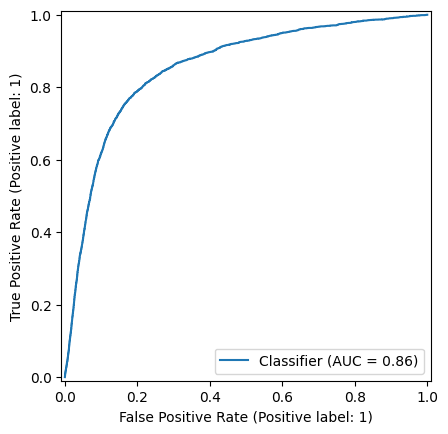

In [18]:
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification report:\n')
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

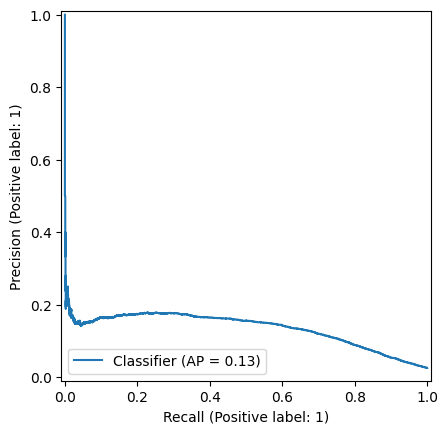

In [23]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_proba)

## 6) Interpretation: Coefficients & Feature Importance
For regularized logistic regression:
- **L2 (Ridge)**: keeps all features but shrinks them
- **L1 (Lasso)**: can push some coefficients to **exactly zero**, performing feature selection
- **Elastic Net**: balances shrinkage + sparsity

We’ll extract feature names after one-hot encoding, and inspect the largest coefficients (by absolute value).


In [19]:
# Extract feature names from the preprocessing step
pre = best_model.named_steps['preprocess']

feature_names = []
if numeric_features:
    feature_names.extend(numeric_features)

if categorical_features:
    ohe = pre.named_transformers_['cat'].named_steps['onehot']
    ohe_names = ohe.get_feature_names_out(categorical_features).tolist()
    feature_names.extend(ohe_names)

coefs = best_model.named_steps['model'].coef_.ravel()
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()

print('Penalty used:', best_model.named_steps['model'].penalty)
print('Non-zero coefficients:', int((coef_df['coef'] != 0).sum()), 'out of', coef_df.shape[0])

display(coef_df.sort_values('abs_coef', ascending=False).head(20))

Penalty used: l1
Non-zero coefficients: 11 out of 11


,feature,coef,abs_coef
0,total_ads,7.393427e-01,7.393427e-01
3,test_group_psa,-2.819398e-01,2.819398e-01
5,most_ads_day_Monday,2.616798e-01,2.616798e-01
1,most_ads_hour,2.267108e-01,2.267108e-01
9,most_ads_day_Tuesday,2.092810e-01,2.092810e-01
6,most_ads_day_Saturday,-2.040208e-01,2.040208e-01
4,most_ads_day_Friday,-1.122453e-01,1.122453e-01
8,most_ads_day_Thursday,-9.029278e-02,9.029278e-02
10,most_ads_day_Wednesday,3.549247e-02,3.549247e-02
2,test_group_ad,2.083249e-06,2.083249e-06


### Visualize top coefficients

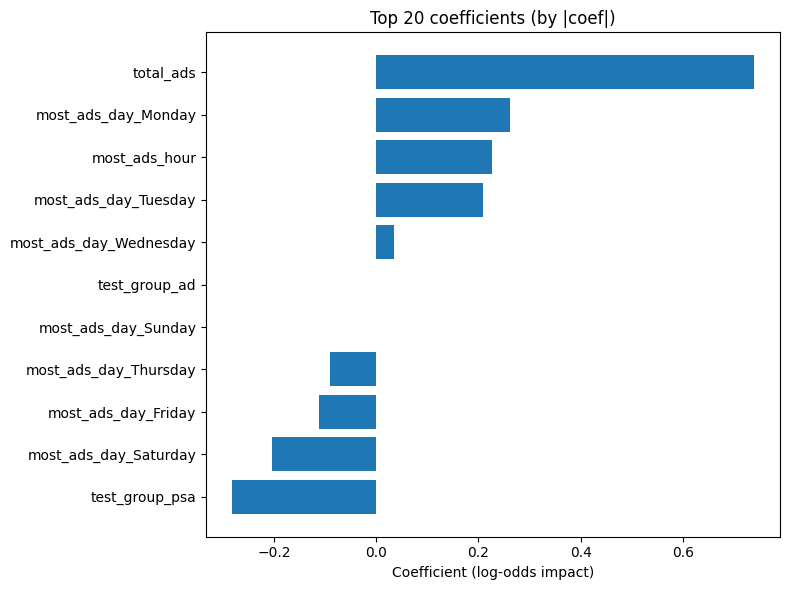

In [20]:
topk = 20
top = coef_df.sort_values('abs_coef', ascending=False).head(topk).sort_values('coef')

plt.figure(figsize=(8, 6))
plt.barh(top['feature'], top['coef'])
plt.xlabel('Coefficient (log-odds impact)')
plt.title(f'Top {topk} coefficients (by |coef|)')
plt.tight_layout()
plt.show()